In [1]:
import os
import re
import nltk
import torch
import random
import unicodedata
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from tqdm import tqdm
from torch import nn
from torch import optim
from copy import deepcopy
from torch.autograd import Variable
from torch.nn import functional as F
from collections import Counter, OrderedDict
from torch.nn.utils.rnn import PackedSequence, pack_padded_sequence, pad_packed_sequence

from torch.utils.data import Dataset, DataLoader

## 번역 데이터셋 다운로드
# !echo "download machine translation dataset from http://www.manythings.org/anki/..."
# !curl -o "fra-eng.zip" "http://www.manythings.org/anki/fra-eng.zip"
# !unzip './fra-eng.zip'

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# 유니코드 문자열을 아스키 문자열로 변환하는 함수
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# 문자열을 정규화하는 함수
def normalize_string(s):
    s = unicode_to_ascii(s.lower().strip())
    s = re.sub(r"([,.!?])", r" \1 ", s) ## 쉼표나 마침표 앞뒤에 공백을 추가.
    s = re.sub(r"[^a-zA-Z,.!?]+", r" ", s) ## 알파벳, 쉼표, 마침표, 느낌표, 물음표를 제외한 모든 문자를 공백으로 대체
    s = re.sub(r"\s+", r" ", s).strip() ## 여러 개의 연속된 공백을 하나의 공백으로 변경
    
    return s


def condition_filtering(norm_sentence, min_length, max_length):
    if len(norm_sentence) >= min_length and len(norm_sentence) <= max_length:
        return norm_sentence
    
def flatten(sentence):
    result = []
    for sublist in sentence:
        for item in sublist:
            result.append(item)

    return result

In [4]:
min_length = 3
max_length = 25
max_corpus = 30000

corpus = open('/home/pervinco/Datasets/fra-eng/fra.txt', 'r', encoding='utf-8').readlines()
corpus = corpus[:max_corpus]

def load_prepare_data():
    X, Y = [], []
    for parallel in tqdm(corpus):
        src, trg, _ = parallel.strip().split('\t')

        if src.strip() == "" or trg.strip() == "":
            continue

        norm_src = normalize_string(src).split() ## 문자열을 공백 문자 기준으로 분할.
        norm_trg = normalize_string(trg).split()

        ## 조건을 만족하는 값만 리스트에 저장.
        if condition_filtering(norm_src, min_length, max_length) and condition_filtering(norm_trg, min_length, max_length):
            X.append(norm_src)
            Y.append(norm_trg)

        ## 소스와 타겟 어휘집을 생성(공백을 기준으로 고유 단어들을 단어집에 추가함)
        source_vocab = list(set(flatten(X)))
        target_vocab = list(set(flatten(Y)))

        # 소스와 타겟 어휘집을 인덱스로 변환하는 딕셔너리 생성
        source2index = {'<PAD>': 0, '<UNK>': 1, '<s>': 2, '</s>': 3}
        for vocab in source_vocab:
            if vocab not in source2index:
                source2index[vocab] = len(source2index)
        index2source = {v: k for k, v in source2index.items()}

        target2index = {'<PAD>': 0, '<UNK>': 1, '<s>': 2, '</s>': 3}
        for vocab in target_vocab:
            if vocab not in target2index:
                target2index[vocab] = len(target2index)
        index2target = {v: k for k, v in target2index.items()}

    return X, Y, source2index, target2index, index2source, index2target

In [5]:
X, Y, source2index, target2index, index2source, index2target = load_prepare_data()

print(X[:10])
print(Y[:10])
print(source2index)
print(target2index)

100%|██████████| 30000/30000 [02:34<00:00, 194.43it/s]

[['i', 'see', '.'], ['i', 'try', '.'], ['i', 'won', '!'], ['i', 'won', '!'], ['i', 'won', '.'], ['oh', 'no', '!'], ['buy', 'it', '.'], ['buy', 'it', '.'], ['buy', 'it', '.'], ['buy', 'it', '.']]
[['je', 'comprends', '.'], ['j', 'essaye', '.'], ['j', 'ai', 'gagne', '!'], ['je', 'l', 'ai', 'emporte', '!'], ['j', 'ai', 'gagne', '.'], ['oh', 'non', '!'], ['achetez', 'la', '!'], ['achete', 'le', '!'], ['achetez', 'le', '!'], ['achete', 'la', '!']]
{'<PAD>': 0, '<UNK>': 1, '<s>': 2, '</s>': 3, 'exaggerating': 4, 'choose': 5, 'alone': 6, 'count': 7, 'front': 8, 'ticklish': 9, 'burn': 10, 'keep': 11, 'grab': 12, 'plenty': 13, 'present': 14, 'scooter': 15, 'answers': 16, 'wonderful': 17, 'latin': 18, 'crook': 19, 'savings': 20, 'charge': 21, 'confess': 22, 'disobeyed': 23, 'overreacting': 24, 'imprecise': 25, 'sale': 26, 'play': 27, 'option': 28, 'jaw': 29, 'tireless': 30, 'hone': 31, 'ticket': 32, 'warned': 33, 'polite': 34, 'popcorn': 35, 'moose': 36, 'memorize': 37, 'wealthy': 38, 'bank': 39

In [6]:
## 문자열을 원소로 갖는 리스트를 정수형 토큰 리스트로 변환.
def sentence_to_indices(seq, to_index):
    ## to_index에 단어가 없는 경우 UNK 토큰으로 변환.
    idxs = [to_index.get(word, to_index['<UNK>']) for word in seq]

    return idxs

class TranslationDataset(Dataset):
    def __init__(self, X, y, source2index, target2index):
        self.X = X
        self.y = y
        self.source2index = source2index
        self.target2index = target2index

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        source_seq = self.X[idx] + ['</s>']
        target_seq = ['<s>'] + self.y[idx] + ['</s>']

        source_indices = sentence_to_indices(source_seq, self.source2index)
        target_indices = sentence_to_indices(target_seq, self.target2index)

        return torch.tensor(source_indices, dtype=torch.long), torch.tensor(target_indices, dtype=torch.long)

## 패딩 및 배치 생성 함수
def collate_fn(batch):
    batch.sort(key=lambda x: len(x[0]), reverse=True)
    source_seqs, target_seqs = zip(*batch)

    source_lengths = [len(seq) for seq in source_seqs]
    target_lengths = [len(seq) for seq in target_seqs]

    ## 현재 batch에서 길이가 가장 긴 시퀀스 데이터의 길이.
    max_source_length = max(source_lengths)
    max_target_length = max(target_lengths)

    ## 다른 데이터 샘플들에 padding을 적용해 길이를 max_length로 통일 시킨다.
    padded_sources = torch.zeros(len(source_seqs), max_source_length, dtype=torch.long)
    padded_targets = torch.zeros(len(target_seqs), max_target_length, dtype=torch.long)

    for i, (source_seq, target_seq) in enumerate(zip(source_seqs, target_seqs)):
        padded_sources[i, :len(source_seq)] = source_seq
        padded_targets[i, :len(target_seq)] = target_seq

    return padded_sources, padded_targets, source_lengths, target_lengths

In [7]:
dataset = TranslationDataset(X, Y, source2index, target2index)
dataloader = DataLoader(dataset, batch_size=256, shuffle=True, collate_fn=collate_fn)

In [8]:
print(dataset[0])

for idx, data in enumerate(dataloader):
    ## data는 (src : [batch_size, seq_len], trg : [batch_size, seq_len])
    print("-" * 10)
    print(data[0].shape, data[1].shape)
    print(data[0][0])
    print(data[1][0])

    if idx == 10:
        break

(tensor([1862, 1687,  868,    3]), tensor([   2, 5342, 3906,  380,    3]))
----------
torch.Size([256, 8]) torch.Size([256, 12])
tensor([ 802, 1857, 3801, 1632, 2482, 3367,  868,    3])
tensor([   2,  596, 4350, 5678, 4499,  962, 6031,  380,    3,    0,    0,    0])
----------
torch.Size([256, 7]) torch.Size([256, 11])
tensor([ 802, 1857,  211, 2245, 3366,  868,    3])
tensor([   2,  616, 7188,  274, 2662,  380,    3,    0,    0,    0,    0])
----------
torch.Size([256, 7]) torch.Size([256, 11])
tensor([1862, 3694, 3767, 1809,  802,  868,    3])
tensor([   2, 5342, 3225,  113, 4499, 1901,  274, 3311,  380,    3,    0])
----------
torch.Size([256, 7]) torch.Size([256, 13])
tensor([3544, 3694, 3767, 1862,  853, 1048,    3])
tensor([   2, 6252, 7188, 3801, 5470, 5342, 4350, 4176, 4499, 1901,  975,  474,
           3])
----------
torch.Size([256, 7]) torch.Size([256, 11])
tensor([1593, 1782,   59, 2920, 2286,  868,    3])
tensor([   2,  616, 7188, 7118,  257, 4350,  380,    3,    0,    0, 

In [9]:
class Encoder(nn.Module):
    def __init__(self, input_size, embedding_size, hidden_size, n_layers=1, bidirec=False, device=None):
        super().__init__()

        self.input_size = input_size ## src_vocab
        self.hidden_size = hidden_size ## hidden_dim
        self.n_layers = n_layers ## layers
        self.device = device

        self.embedding = nn.Embedding(input_size, embedding_size) ## [batch_size, seq_len, embedding_dim]

        if bidirec:
            self.n_direction = 2
            self.gru = nn.GRU(embedding_size, hidden_size, n_layers, batch_first=True, bidirectional=True)
        else:
            self.n_direction = 1
            self.gru = nn.GRU(embedding_size, hidden_size, n_layers, batch_first=True)

    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers * self.n_direction, batch_size, self.hidden_size)
        return hidden.to(self.device) if self.device else hidden


    def init_weight(self):
        nn.init.xavier_uniform_(self.embedding.weight)
        for name, param in self.gru.named_parameters():
            if 'weight' in name:
                nn.init.xavier_uniform_(param)

    def forward(self, inputs, input_lengths):
        hidden = self.init_hidden(inputs.size(0))

        embedded = self.embedding(inputs)

        ## pack_padded_sequence
        ## 패딩된 시퀀스를 입력으로 받아 패딩되지 않은 시퀀스로 변환.
        ## RNN 계열에 입력하기 이전에 padding 토큰을 제거해 학습에 적용되지 않게함.
        packed = pack_padded_sequence(embedded, input_lengths, batch_first=True)

        ## 모델에 입력
        outputs, hidden = self.gru(packed, hidden)

        ## pad_packed_sequence
        ## 패딩되지 않은 시퀀스를 입력으로 받아 패딩된 시퀀스로 변환한다.
        outputs, _ = pad_packed_sequence(outputs, batch_first=True)

        if self.n_layers > 1:
            if self.n_direction == 2:
                hidden = hidden[-2:]
            else:
                hidden = hidden[-1]

        hidden = torch.cat([h for h in hidden], 1).unsqueeze(1)
        
        return outputs, hidden

In [14]:
class Decoder(nn.Module):
    # 초기화 함수
    def __init__(self, input_size, embedding_size, hidden_size, n_layers=1, dropout_p=0.1, device=None):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.device = device

        self.embedding = nn.Embedding(input_size, embedding_size)
        
        ## 드롭아웃 레이어를 생성. 드롭아웃 확률을 인자로 받음
        self.dropout = nn.Dropout(dropout_p)
        
        ## GRU 레이어를 생성. 임베딩 크기 + 은닉층 크기, 은닉층 크기, 레이어 수를 인자로 받음
        self.gru = nn.GRU(embedding_size + hidden_size, hidden_size, n_layers, batch_first=True)
        
        ## 선형 레이어를 생성. 은닉층 크기 * 2, 입력 크기를 인자로 받음
        self.linear = nn.Linear(hidden_size * 2, input_size)
        
        ## Attention 레이어를 생성. 은닉층 크기를 인자로 받음
        self.attn = nn.Linear(self.hidden_size, self.hidden_size)

    # 은닉 상태를 초기화하는 함수
    def init_hidden(self,inputs):
        # 은닉 상태를 0으로 초기화
        hidden = Variable(torch.zeros(self.n_layers, inputs.size(0), self.hidden_size))
        
        return hidden.to(self.device) if self.device else hidden

    # 가중치를 초기화하는 함수
    def init_weight(self):
        self.embedding.weight = nn.init.xavier_uniform(self.embedding.weight)
        self.gru.weight_hh_l0 = nn.init.xavier_uniform(self.gru.weight_hh_l0)
        self.gru.weight_ih_l0 = nn.init.xavier_uniform(self.gru.weight_ih_l0)
        self.linear.weight = nn.init.xavier_uniform(self.linear.weight)
        self.attn.weight = nn.init.xavier_uniform(self.attn.weight)

    # Attention 메커니즘을 구현하는 함수
    def Attention(self, hidden, encoder_outputs, encoder_maskings):
        """
        hidden : 1,B,D
        encoder_outputs : B,T,D
        encoder_maskings : B,T # ByteTensor
        """
        # hidden의 차원을 변경
        hidden = hidden[0].unsqueeze(2)  # (1,B,D) -> (B,D,1)

        # encoder_outputs의 크기를 가져옴
        batch_size = encoder_outputs.size(0) # B
        max_len = encoder_outputs.size(1) # T
        # attention 에너지를 계산
        energies = self.attn(encoder_outputs.contiguous().view(batch_size * max_len, -1)) # B*T,D -> B*T,D
        energies = energies.view(batch_size,max_len, -1) # B,T,D
        attn_energies = energies.bmm(hidden).squeeze(2) # B,T,D * B,D,1 --> B,T

        # softmax를 사용하여 attention 가중치를 계산
        alpha = F.softmax(attn_energies,1) # B,T
        alpha = alpha.unsqueeze(1) # B,1,T
        # context 벡터를 계산
        context = alpha.bmm(encoder_outputs) # B,1,T * B,T,D => B,1,D

        return context, alpha

    def forward(self, inputs, context, max_length, encoder_outputs, targets=None, is_training=False):
        embedded = self.embedding(inputs)
        hidden = self.init_hidden(inputs)
        hidden_last = hidden[-1].unsqueeze(0)
        if is_training:
            embedded = self.dropout(embedded)

        decode = []
        for i in range(max_length):
            # GRU 업데이트
            _, hidden = self.gru(torch.cat((embedded, context), 2), hidden)
            hidden_last = hidden[-1].unsqueeze(0)
            # hidden_last와 context 결합
            concated = torch.cat((hidden_last, context.transpose(0, 1)), 2)
            # 출력 계산
            score = self.linear(concated.squeeze(0))
            softmaxed = F.log_softmax(score, dim=1)
            decode.append(softmaxed)
            if is_training and targets is not None:
                # Teacher Forcing 사용
                decoded = targets[:, i].unsqueeze(1)
            else:
                # 모델의 예측값 사용
                decoded = softmaxed.max(1)[1].unsqueeze(1)
            embedded = self.embedding(decoded)
            if is_training:
                embedded = self.dropout(embedded)
            context, _ = self.Attention(hidden, encoder_outputs, None)

        scores = torch.stack(decode, dim=1)
        return scores.view(inputs.size(0) * max_length, -1)


    def decode(self, context, encoder_outputs):
        # 디코딩을 시작하는 심볼을 start_decode에 저장
        start_decode = torch.LongTensor([[target2index['<s>']]]).to(context.device)  # 디바이스 이동
        start_decode = start_decode.transpose(0, 1)
        # start_decode를 임베딩
        embedded = self.embedding(start_decode)
        # 은닉 상태를 초기화
        hidden = self.init_hidden(start_decode)
        
        decodes = []
        attentions = []
        decoded = embedded
        while True:
            _, hidden = self.gru(torch.cat((embedded, context), 2), hidden)
            concated = torch.cat((hidden[-1].unsqueeze(0), context.transpose(0, 1)), 2)
            score = self.linear(concated.squeeze(0))
            softmaxed = F.log_softmax(score, dim=1)
            topv, topi = softmaxed.topk(1)
            pred_token = topi.item()
            decodes.append(pred_token)
            if pred_token == target2index['</s>'] or len(decodes) > 50:
                break
            decoded = torch.LongTensor([[pred_token]]).to(context.device)  # 디바이스 이동
            embedded = self.embedding(decoded)
            context, alpha = self.Attention(hidden, encoder_outputs, None)
            attentions.append(alpha.squeeze(1))
        
        return decodes, attentions


In [15]:
# 학습에 필요한 파라미터 설정
EPOCHS = 5  # 총 학습할 epoch 수
BATCH_SIZE = 256  # 한 번에 학습할 데이터의 수
EMBEDDING_SIZE = 300  # 임베딩 벡터의 차원 수
HIDDEN_SIZE = 512  # 히든 레이어의 노드 수
LEARNING_RATE = 0.001  # 학습률
TEACHER_FORCING_RATIO = 0.5  # Teacher Forcing의 비율

# 인코더와 디코더 객체 생성
encoder = Encoder(len(source2index), EMBEDDING_SIZE, HIDDEN_SIZE, n_layers=3, bidirec=True, device=device).to(device)
decoder = Decoder(len(target2index), EMBEDDING_SIZE, HIDDEN_SIZE * 2, n_layers=3, dropout_p=0.1, device=device).to(device)

# 인코더와 디코더의 가중치 초기화
encoder.init_weight()
decoder.init_weight()

# 손실 함수 설정 (CrossEntropyLoss 사용, 패딩된 부분은 무시)
criterion = nn.CrossEntropyLoss(ignore_index=target2index['<PAD>'])

# 최적화 함수 설정 (Adam 사용)
encoder_optimizer = optim.Adam(encoder.parameters(), lr=LEARNING_RATE)
decoder_optimizer = optim.Adam(decoder.parameters(), lr=LEARNING_RATE * 5)

for epoch in range(EPOCHS):
    encoder.train()
    decoder.train()

    epoch_loss = 0
    for batch_idx, (source_seqs, target_seqs, source_lengths, target_lengths) in enumerate(dataloader):
        source_seqs, target_seqs = source_seqs.to(device), target_seqs.to(device)
        batch_size = source_seqs.size(0)

        # Optimizer 초기화
        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        # 인코더 순전파
        encoder_outputs, hidden = encoder(source_seqs, source_lengths)

        # 디코더 입력 및 context 설정
        start_token = target_seqs[:, 0].unsqueeze(1)  # '<s>'
        context = hidden

        # 디코더 순전파 (Teacher Forcing 적용)
        preds = decoder(start_token, context, max(target_lengths)-1, encoder_outputs, targets=target_seqs[:, 1:], is_training=True)

        # 타겟 시퀀스 변환
        targets = target_seqs[:, 1:].contiguous().view(-1)

        # 손실 계산
        loss = criterion(preds, targets)

        # 역전파 및 최적화
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(decoder.parameters(), max_norm=1.0)

        # Optimizer 업데이트
        encoder_optimizer.step()
        decoder_optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{EPOCHS}], Loss: {epoch_loss / len(dataloader):.4f}")


/tmp/ipykernel_447521/2597552438.py:32: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  self.embedding.weight = nn.init.xavier_uniform(self.embedding.weight)
/tmp/ipykernel_447521/2597552438.py:33: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  self.gru.weight_hh_l0 = nn.init.xavier_uniform(self.gru.weight_hh_l0)
/tmp/ipykernel_447521/2597552438.py:34: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  self.gru.weight_ih_l0 = nn.init.xavier_uniform(self.gru.weight_ih_l0)
/tmp/ipykernel_447521/2597552438.py:35: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  self.linear.weight = nn.init.xavier_uniform(self.linear.weight)
/tmp/ipykernel_447521/2597552438.py:36: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  self.attn.weight = nn.init.xavi

Epoch [1/5], Loss: 4.4729
Epoch [2/5], Loss: 2.9733
Epoch [3/5], Loss: 2.2950
Epoch [4/5], Loss: 1.8183
Epoch [5/5], Loss: 1.5022


Source : he stood up .
Truth : il se mit debout .
Prediction : il s leve debout . </s>


/tmp/ipykernel_447521/559064510.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + input_words, rotation=90)
/tmp/ipykernel_447521/559064510.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + output_words)


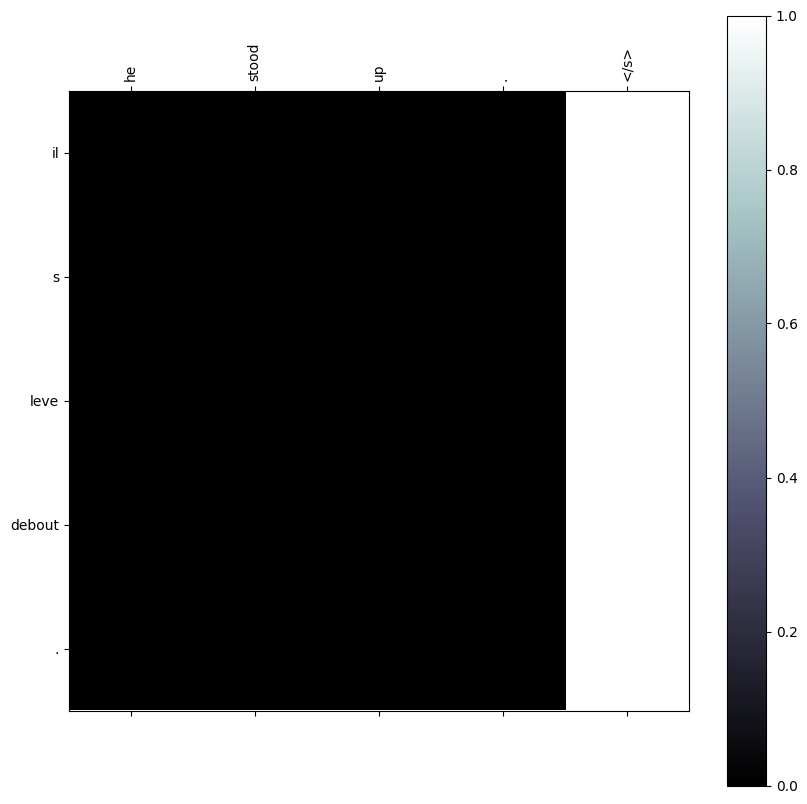

In [18]:
def show_attention(input_words, output_words, attentions):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone')
    fig.colorbar(cax)
    
    ax.set_xticklabels([''] + input_words, rotation=90)
    ax.set_yticklabels([''] + output_words)
    
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.show()
    plt.close()

def evaluate_randomly(encoder, decoder, dataset, index2source, index2target):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        idx = random.randint(0, len(dataset) - 1)
        input_seq, target_seq = dataset[idx]
        input_seq = input_seq.unsqueeze(0).to(device)
        input_length = [len(input_seq[0])]

        # 인코더를 통해 출력과 은닉 상태 얻음
        encoder_outputs, hidden = encoder(input_seq, input_length)
        context = hidden

        # 디코더를 통해 예측값과 Attention 얻음
        pred_indices, attentions = decoder.decode(context, encoder_outputs)

        # 단어로 변환
        input_words = [index2source[i.item()] for i in input_seq[0]]
        pred_words = [index2target[i] for i in pred_indices]
        target_words = [index2target[i.item()] for i in target_seq if i.item() not in [target2index['<PAD>']]]

        # 결과 출력
        print('Source :', ' '.join([word for word in input_words if word != '</s>']))
        print('Truth :', ' '.join([word for word in target_words if word not in ['<s>', '</s>']]))
        print('Prediction :', ' '.join(pred_words))

        # Attention 시각화를 위해 텐서를 NumPy 배열로 변환
        attentions = torch.stack(attentions).squeeze(1).cpu().numpy()

        show_attention(input_words, pred_words, attentions)

evaluate_randomly(encoder, decoder, dataset, index2source, index2target)